In [1]:
from visualization import HiderSeekerEnv
import numpy as np
import random
import pygame
import os
import tensorflow as tf
import matplotlib.pyplot as plt

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
class SARSA_Agent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, alpha_decay=0.99):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.alpha_decay = alpha_decay
        self.episode_steps = []  # Track steps per episode
        self.q_table = {}
        self.total_rewards = []  # List to store rewards for each episode
        self.losses = []  # List to store loss for each episode
        self.exploration_rates = []  # List to store exploration rates for each episode
        self.learning_rates = []  # List to store learning rates for each episode

        # TensorBoard Summary Writer Setup
        self.log_dir = "logs/sarsa"  # Log directory for TensorBoard
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.env.actions)  # Explore
        else:
            q_values = [self.get_q_value(state, action) for action in self.env.actions]
            max_q_value = max(q_values)
            return self.env.actions[q_values.index(max_q_value)]  # Exploit

    def update_q_table(self, state, action, reward, next_state, next_action):
        q_value = self.get_q_value(state, action)
        next_q_value = self.get_q_value(next_state, next_action)
        updated_q_value = q_value + self.alpha * (reward + self.gamma * next_q_value - q_value)
        self.q_table[(state, action)] = updated_q_value

    def log_episode(self, episode, total_reward, episode_loss):
        # Create log entry for the current episode
        log_entry = {
            'episode': episode,
            'total_reward': total_reward,
            'loss': episode_loss,
            'epsilon': self.epsilon,
            'alpha': self.alpha
        }
        self.total_rewards.append(total_reward)
        self.losses.append(episode_loss)
        self.exploration_rates.append(self.epsilon)
        self.learning_rates.append(self.alpha)

        # Log to TensorBoard for each metric
        with self.writer.as_default():
            tf.summary.scalar('Total Reward', total_reward, step=episode)
            tf.summary.scalar('Loss', episode_loss, step=episode)
            tf.summary.scalar('Epsilon', self.epsilon, step=episode)
            tf.summary.scalar('Alpha', self.alpha, step=episode)
        
        # Print log to the console
        print(f"Episode: {episode}, Total Reward: {total_reward}, Loss: {episode_loss}, "
              f"Epsilon: {self.epsilon:.4f}, Alpha: {self.alpha:.4f}")

    def train(self, episodes=1000):
        # Create a folder for storing training graphs (EXP2 folder)
        if not os.path.exists('EXP2'):
            os.makedirs('EXP2')

        # Initialize TensorBoard
        self.writer.set_as_default()
        # List to store steps per episode
        

        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            done = False
            episode_loss = 0
            steps = 0  # Track steps in each episode
        

            while not done:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                total_reward += reward
                state = next_state
                action = next_action
                steps += 1  # Increment the step counter

                # Track total loss (cumulative reward loss for each episode)
                episode_loss += reward  # You can modify this to reflect the loss function

            # Log the episode details for TensorBoard
            self.log_episode(episode + 1, total_reward, episode_loss)

            # Append steps per episode
            self.episode_steps.append(steps)
            # Decay epsilon (exploration rate) and alpha (learning rate)
            self.epsilon = max(self.epsilon * self.epsilon_decay, 0.1)
            self.alpha = max(self.alpha * self.alpha_decay, 0.01)

            # Save combined graph after every 40 episodes
            if (episode + 1) % 40 == 0:
                self.plot_and_save_combined_graphs(episode + 1)

    def steps_per_episode(self):
        plt.figure(figsize=(14, 6))
        # Plot total steps per episode
        #plt.subplot(1, 2, 1)
        plt.plot(self.episode_steps, label="Total Steps per Episode", color='green')
        plt.xlabel("Episode")
        plt.ylabel("Total Steps")
        plt.title("Total Steps per Episode")
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    def plot_and_save_combined_graphs(self, episode):
        # Combined Graph for Total Rewards, Losses, Exploration Rate, and Learning Rate
        plt.figure(figsize=(12, 8))

        # Total Reward graph
        plt.subplot(2, 2, 1)
        plt.plot(range(1, episode + 1), self.total_rewards, label='Total Reward per Episode')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title(f'Total Reward over Episodes (Episodes: {episode})')
        plt.grid(True)

        # Loss graph
        plt.subplot(2, 2, 2)
        plt.plot(range(1, episode + 1), self.losses, label='Loss per Episode', color='red')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.title(f'Loss over Episodes (Episodes: {episode})')
        plt.grid(True)

        # Exploration Rate graph
        plt.subplot(2, 2, 3)
        plt.plot(range(1, episode + 1), self.exploration_rates, label='Exploration Rate', color='green')
        plt.xlabel('Episodes')
        plt.ylabel('Exploration Rate')
        plt.title(f'Exploration Rate over Episodes (Episodes: {episode})')
        plt.grid(True)

        # Learning Rate graph
        plt.subplot(2, 2, 4)
        plt.plot(range(1, episode + 1), self.learning_rates, label='Learning Rate', color='blue')
        plt.xlabel('Episodes')
        plt.ylabel('Learning Rate')
        plt.title(f'Learning Rate over Episodes (Episodes: {episode})')
        plt.grid(True)

        # Save the combined plot as one image
        plt.tight_layout()
        plt.savefig(f'EXP2/combined_graphs_{episode}.png')
        plt.close()

Episode: 1, Total Reward: -156.0, Loss: -156.0, Epsilon: 1.0000, Alpha: 0.1000
Episode: 2, Total Reward: 40.5, Loss: 40.5, Epsilon: 0.9950, Alpha: 0.0990
Episode: 3, Total Reward: -33.0, Loss: -33.0, Epsilon: 0.9900, Alpha: 0.0980
Episode: 4, Total Reward: 71.5, Loss: 71.5, Epsilon: 0.9851, Alpha: 0.0970
Episode: 5, Total Reward: 63.5, Loss: 63.5, Epsilon: 0.9801, Alpha: 0.0961
Episode: 6, Total Reward: -182.0, Loss: -182.0, Epsilon: 0.9752, Alpha: 0.0951
Episode: 7, Total Reward: -172.5, Loss: -172.5, Epsilon: 0.9704, Alpha: 0.0941
Episode: 8, Total Reward: -41.5, Loss: -41.5, Epsilon: 0.9655, Alpha: 0.0932
Episode: 9, Total Reward: 74.0, Loss: 74.0, Epsilon: 0.9607, Alpha: 0.0923
Episode: 10, Total Reward: 58.5, Loss: 58.5, Epsilon: 0.9559, Alpha: 0.0914
Episode: 11, Total Reward: -246.0, Loss: -246.0, Epsilon: 0.9511, Alpha: 0.0904
Episode: 12, Total Reward: -31.0, Loss: -31.0, Epsilon: 0.9464, Alpha: 0.0895
Episode: 13, Total Reward: -126.5, Loss: -126.5, Epsilon: 0.9416, Alpha: 0.

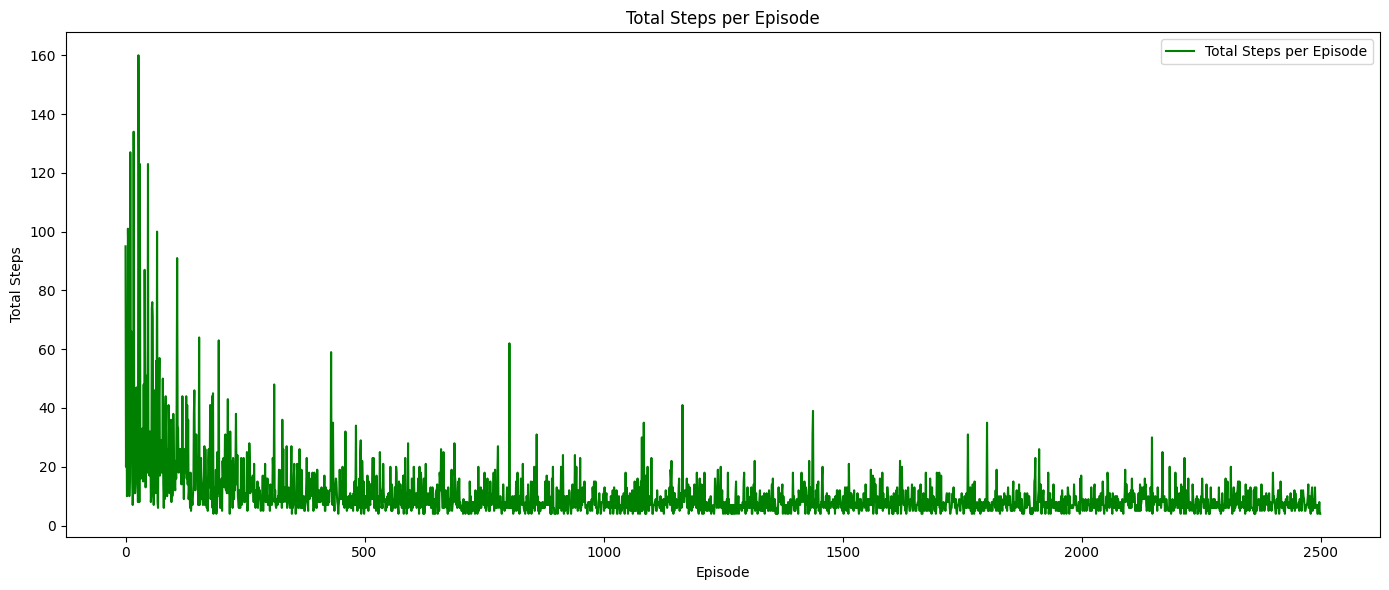

Training completed.
Final Q-table: {(((0, 0), (4, 4)), (-1, 0)): 8.572568160942032, (((0, 1), (3, 4)), (1, 0)): -3.4974749638615696, (((0, 2), (4, 4)), (0, -1)): -2.0941706318008113, (((1, 2), (4, 3)), (-1, 0)): -1.0990643211067237, (((0, 2), (4, 3)), (-1, 0)): -2.594862470075718, (((0, 3), (4, 3)), (-1, 0)): -1.376389869617202, (((1, 3), (4, 3)), (0, 1)): -1.4627725342470972, (((1, 4), (4, 4)), (1, 0)): -1.1659128514076136, (((1, 3), (4, 4)), (0, -1)): -1.6792212078705284, (((1, 2), (4, 3)), (1, 0)): -1.0241348692852865, (((1, 3), (4, 3)), (0, -1)): -0.9944710392714605, (((1, 4), (4, 2)), (-1, 0)): -0.8446031679083563, (((0, 4), (3, 2)), (0, 1)): -0.422722997953599, (((0, 3), (3, 2)), (0, -1)): -0.5861402827866924, (((0, 2), (3, 2)), (-1, 0)): -0.7846479213813458, (((0, 1), (2, 2)), (1, 0)): -0.3234406379299558, (((0, 3), (2, 2)), (1, 0)): -0.5677100799203352, (((1, 3), (3, 2)), (0, 1)): -0.7838775223568778, (((0, 3), (3, 2)), (0, 1)): -1.1233093415220667, (((0, 2), (3, 2)), (1, 0)): 

In [5]:

# Main execution
if __name__ == "__main__":
    env = HiderSeekerEnv(grid_size=5, screen_width=500, screen_height=500)  # Initialize environment
    agent = SARSA_Agent(env)

    # Train the agent
    agent.train(episodes=2500)  # Set the number of episodes
    agent.steps_per_episode()
    # Display final learned Q-values (or another summary)
    print("Training completed.")
    print("Final Q-table:", agent.q_table)

    # Show combined graphs for the final episode
    agent.plot_and_save_combined_graphs(episode=2500)
    
    # Clean up and close the environment
    env.close()

### command to check logs for Sarsa
##### tensorboard --logdir=logs/sarsa